# 3. Experimentieren
Basierend auf diesen Daten können nun weitere Experimente zur Analyse und Visualisierung dieser Daten durchgeführt werden.
Im folgenden sind zwei Experimente implementiert: Boxplot zur Darstellung der 

In [2]:
import json
from collections import defaultdict


mode = 1
# 1 = Nationalratswahlen

filename = "nationalrat_raw.json"
candidates = json.load(open(filename, encoding="utf-8"))

/tmp/ipykernel_149142/1826435866.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='partyAbbreviation', y='answer', data=filtered_answer_df, palette='Set2', showfliers=False)


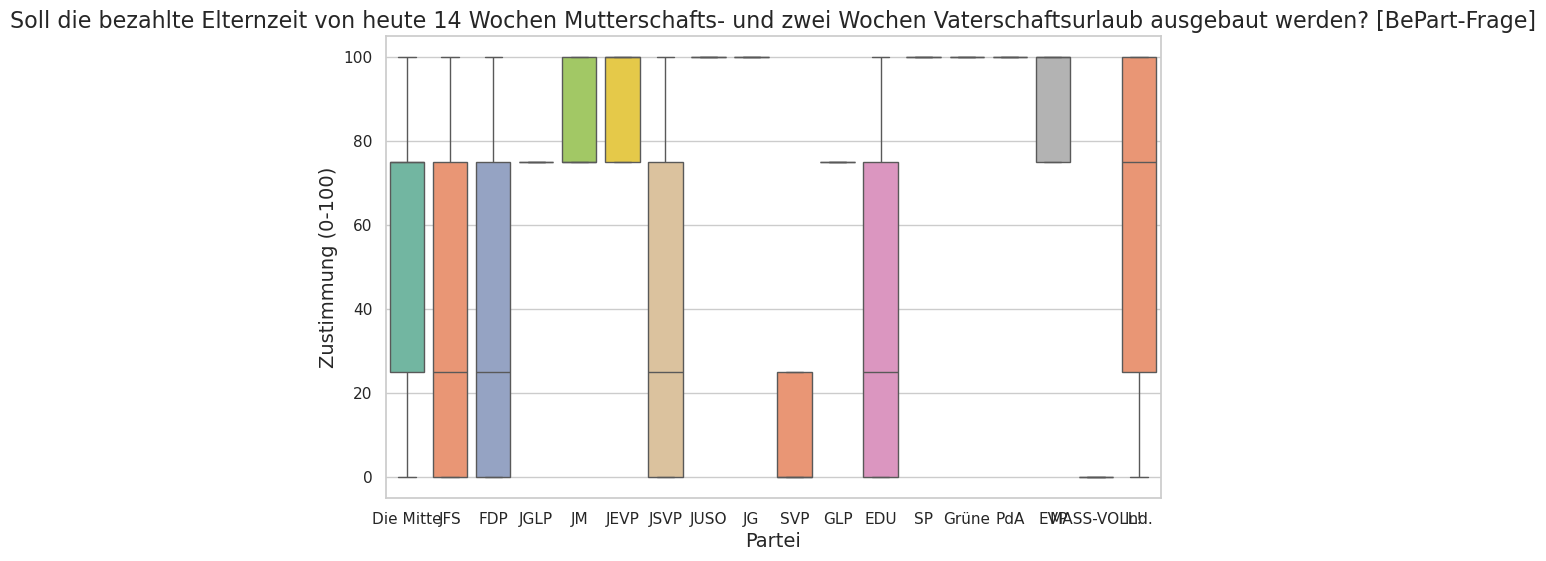

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Daten in ein Pandas DataFrame umwandeln (für die bessere Handhabung)
df = pd.DataFrame(candidates)
answer_data = []
frage = df.head(1)['answers'][0][0]['text']
for idx, row in df.iterrows():
    for answer in row["answers"]:
       # Definiere die Frage, die du visualisieren möchtest
       if answer["questionId"] == "32215":
        answer_data.append({
            "id": row["id"],
            "firstname": row["firstname"],
            "lastname": row["lastname"],
            "partyAbbreviation": row["partyAbbreviation"],
            "partyColor": row["partyColor"],
            "questionId": answer["questionId"],
            "answer": int(answer["value"])
            })
answer_df = pd.DataFrame(answer_data)
# Filtere Parteien mit weniger als 100 Kantidaten
party_counts = answer_df['partyAbbreviation'].value_counts()
parties_to_keep = party_counts[party_counts > 75].index
filtered_answer_df = answer_df[answer_df['partyAbbreviation'].isin(parties_to_keep)]


plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid")

# Create the box plot with Party Abbreviation as the x-axis and answers as the y-axis
sns.boxplot(x='partyAbbreviation', y='answer', data=filtered_answer_df, palette='Set2', showfliers=False)

# Customize the plot
plt.title(frage, fontsize=16)
plt.xlabel("Partei", fontsize=14)
plt.ylabel("Zustimmung (0-100)", fontsize=14)

plt.show()


# Analyse der Abweichler-Raten


In [27]:
import pandas as pd
import numpy as np

df = pd.DataFrame(candidates)

expanded_answers = []
for idx, row in df.iterrows():
    for answer in row["answers"]:
        expanded_answers.append({
            "candidate_id": row["id"],
            "firstname": row["firstname"],
            "lastname": row["lastname"],
            "partyAbbreviation": row["partyAbbreviation"],
            "questionId": answer["questionId"],
            "answer": answer["value"]
        })

answers_df = pd.DataFrame(expanded_answers)

# Berechnet den Durchschnitt der Antworten für jede Partei und jede Frage
party_averages = answers_df.groupby(['partyAbbreviation', 'questionId'])['answer'].mean().reset_index()
party_averages.rename(columns={'answer': 'party_avg'}, inplace=True)

# Fügt den durchschnittlichen Partei-Antworten zu den individuellen Antworten hinzu
answers_with_avg = pd.merge(answers_df, party_averages, on=['partyAbbreviation', 'questionId'])

# Berechnet die Abweichung der Antwort von der durchschnittlichen Parteiantwort
answers_with_avg['deviation'] = np.abs(answers_with_avg['answer'] - answers_with_avg['party_avg'])

# Berechnet die durchschnittliche Abweichung für jeden Kandidaten
candidate_deviations = answers_with_avg.groupby(['candidate_id', 'firstname', 'lastname', 'partyAbbreviation'])['deviation'].mean().reset_index()

# Nun Formattieren wir die Daten für die Ausgabe
# Zuerst benennen wir die Spalten auf Deutsch um
candidate_deviations.rename(columns={
    'candidate_id': 'ID',
    'firstname': 'Vorname',
    'lastname': 'Nachname',
    'partyAbbreviation': 'Partei',
    'deviation': 'Abweichung'
}, inplace=True)

candidate_deviations = candidate_deviations[candidate_deviations['Partei'] != 'Ind.']  # Die unabhängigen Kandidaten entfernen

candidate_deviations.set_index('ID', inplace=True)


# Sortiert die Kandidaten nach der durchschnittlichen Abweichung
most_dissenting_candidates = candidate_deviations.sort_values(by='Abweichung', ascending=False)

display_df = most_dissenting_candidates.reset_index() # Nummeriert von 0 an die Resultate durch
display_df.index += 1   # Nummerierung soll bei 1 beginnen


# Ausgabe der ersten 20 Kandidierenden
print(display_df.head(20))


       ID      Vorname      Nachname     Partei  Abweichung
1   53854        Simon    Hostettler       JEVP   45.566833
2   55472         Marc     Allenbach        GLP   44.780694
3   55838        Cyril          Nobs        SVP   44.744964
4   58044       Moreno       Colombo        FDP   44.418586
5   53947        Savio     Michellod        FDP   43.711111
6   56607         Luka     Vojinovic  Die Mitte   43.597932
7   54102        Laure    Vouillamoz        JFS   43.379237
8   56177  Hans Rudolf         Lüthi  Die Mitte   43.125507
9   59448       Carola        Barchi        FDP   43.051313
10  57652        Dusan       Konatar        SVP   42.951734
11  58106       Nicole       Giudici         JM   42.863563
12  59249        Erika       Strobel  Die Mitte   42.817681
13  57478          Urs       Schärer  engagiert   42.806154
14  58129       Giulia     Petrimpol         JM   42.795287
15  55909        Alois        Felder  Die Mitte   42.627382
16  56768       Jeremy        Kuwegu    

/tmp/ipykernel_197920/3215375373.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_parties.index, y=top_10_parties['% High Deviators'], palette='Set2')


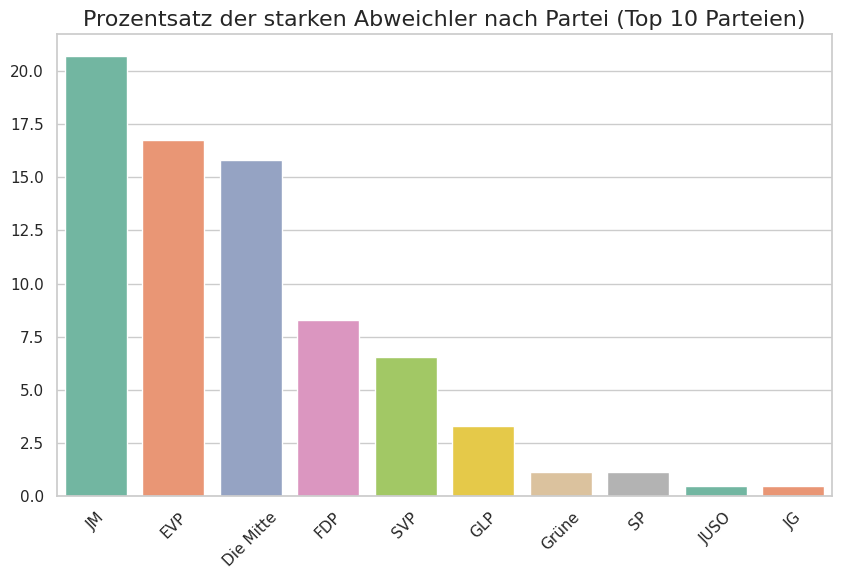

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

def categorize_deviation(dev):
    if dev > 30:
        return "High Deviator"
    elif dev > 15:
        return "Moderate Deviator"
    else:
        return "Aligned"

# Abweichler-Kategorisierung hinzufügen
candidate_deviations['Abweichler-Grad'] = candidate_deviations['Abweichung'].apply(categorize_deviation)

# Anzahl Mitglieder pro Partei und Abweichler-Grad zählen
deviator_stats = candidate_deviations.groupby(['Partei', 'Abweichler-Grad']).size().unstack(fill_value=0)

# Anzahl Mitglieder pro Partei hinzufügen
deviator_stats['Gesamt'] = deviator_stats.sum(axis=1)

# Anteil der starken Abweichler berechnen
deviator_stats['% High Deviators'] = (deviator_stats['High Deviator'] / deviator_stats['Gesamt']) * 100

# Nur die häufigen Parteien behalten
top_10_parties = deviator_stats.sort_values(by='Gesamt', ascending=False).head(10)

# Sortierung nach dem Prozentsatz der starken Abweichler
top_10_parties = top_10_parties.sort_values(by='% High Deviators', ascending=False)

# Erstellung des Balkendiagramms
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_parties.index, y=top_10_parties['% High Deviators'], palette='Set2')
plt.title("Prozentsatz der starken Abweichler nach Partei (Top 10 Parteien)", fontsize=16)
plt.xlabel("")
plt.ylabel("")
plt.xticks(rotation=45)
plt.show()